
Mach-zender_interferometer_time_main

stept [s]
2.00000E-16

Optical Frequency: freq1 [Hz]
1.93414E+14



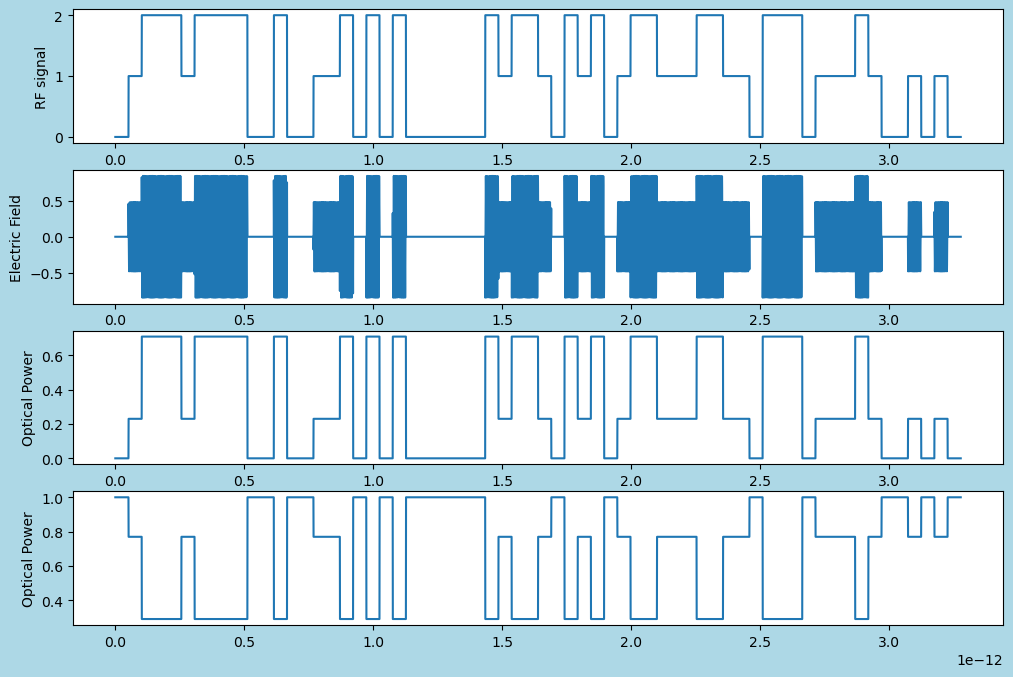

In [1]:

import numpy as np
import matplotlib.pyplot as plt

import mach_zender_interferometer_time_def
from scipy.constants import c 

print('')
print('Mach-zender_interferometer_time_main')
print('')

samplerate = 16384 # NUmber of Points
stept = 0.2*1e-15

print("stept [s]")
print(f'{stept:.5E}')
print('')

tcol = np.linspace(0.0, stept * samplerate, samplerate, endpoint=False)

wl1 = 1550e-9 #wavelength [m]

freq1 = c / wl1
print("Optical Frequency: freq1 [Hz]")
print(f'{freq1:.5E}')
print("")

no = 1 # Refractive Index of medium

oplcommon1=1 #Common Path Length 1
oplcommon2=1 #Common Path Length 2


PT1 = 0.5 # PT: Power Transmission of first beam splitter
PT2 = 0.5 # PT: Power Transmission of second beam splitter

#Sine signal parameters

amp_c = 0.5 * np.pi
freq_rf = 100e9 # [Hz]

dc_offset = -0.5*np.pi # DC offset

sine_signalcol = np.zeros(samplerate)

for ii in range(samplerate):    
    
    t = tcol[ii]

    sinesignal = amp_c * np.sin(2 * np.pi * freq_rf * t) + dc_offset
    sine_signalcol[ii] = sinesignal  




# Pseudo Random multilevel Digital signal, type 1

a_range = [0, 1]
a = np.random.rand(samplerate) * (a_range[1]-a_range[0]) + a_range[0] # range for amplitude

b_range = [300, 600]
b = np.random.rand(samplerate) *(b_range[1]-b_range[0]) + b_range[0] # range for frequency
b = np.round(b)
b = b.astype(int)

b[0] = 0

for i in range(1,np.size(b)):
    b[i] = b[i-1]+b[i]

i=0
random_signal = np.zeros(samplerate)
while b[i]<np.size(random_signal):
    k = b[i]
    random_signal[k:] = a[i]
    i=i+1


# Pseudo Random multilevel Digital signal, type 1

a = np.zeros(samplerate)
j = 0
while j < samplerate:
    a[j] = 1*np.pi + 0*np.pi
    a[j+1] = 0*np.pi
    j = j+2

i=0
prbs1 = np.zeros(samplerate)
while b[i]<np.size(prbs1):
    k = b[i]
    prbs1[k:] = a[i]
    i=i+1
#----


# Pseudo Random multilevel Digital signal, type 2
amp_prbs2 = 1
numberofpointspersinal = 2 ** 6
repetitions1 = samplerate / numberofpointspersinal

rand_int2 = np.random.randint(0, 3, numberofpointspersinal) # 0 or 1
prbs2 = amp_prbs2 * np.repeat(rand_int2, repetitions1)
#prbs2 = np.repeat([0,1,0,1,1,0,1,0], repetitions1)


# Select signal source

#signalcol = sine_signalcol
#signalcol = random_signal
#signalcol = prbs1
signalcol = prbs2

#Define Input condition

# Input Port 1 only
Ein1 = np.array([[1+0.0000j],[0-0.0000j]])
#Ein1 = np.array([[0.707+0.707j],[0]])

# Input Both 1 and 2 port
#Ein1 = np.array([[1+0j],[1-0j]]) 
#Ein1 = np.array([[0.707+0.707j],[-0.707-0.707j]])
#Ein1 = np.array([[1 + 0j],[-1 - 0j]])

# Input Port 2 only
#Ein1 = np.array([[0],[1]]) 
#Ein1 = np.array([[0],[0.707+0.707j]])


P1_powercol = np.zeros(samplerate)

P2_powercol = np.zeros(samplerate)

Eout_port1col = np.zeros(samplerate, dtype=complex)
Eout_port2col = np.zeros(samplerate, dtype=complex)

for ii in range(samplerate):
    
    t = tcol[ii]   
    signal = signalcol[ii]
    
    Eout1 = mach_zender_interferometer_time_def.propagate1(oplcommon1, oplcommon2, Ein1)
    Ein2 = Eout1
    
    Eout2 = mach_zender_interferometer_time_def.beamsplitter(PT1, Ein2)
    Ein3 = Eout2
    
    phase1 = 2*np.pi * freq1 * t # phase of local oscillator [rad]
    phase2 = phase1 + signal #[rad]

    Eout3 = mach_zender_interferometer_time_def.propagate1(phase1, phase2, Ein3) # Each path experience different path length
    Ein4 = Eout3
    
    Eout4 = mach_zender_interferometer_time_def.beamsplitter(PT2, Ein4) # Each path enter second beam splitter
    Ein5 = Eout4
    
    Eout5 = mach_zender_interferometer_time_def.propagate1(oplcommon1, oplcommon2, Ein5)
    Ein6 = Eout5
    
    Eout_port1 = Ein6[0,0] 
    Eout_port1col[ii] = Eout_port1

    power_11 = (np.abs(Eout_port1))**2 # Optical power is calculated as square of absolute electric field strength
    P1_powercol[ii] = power_11
    
   
    Eout_port_2 = Ein6[1,0]
    Eout_port2col[ii] = Eout_port_2

    power_22 = (np.abs(Eout_port_2))**2
    P2_powercol[ii] = power_22
    
 
fig = plt.figure(figsize = (12,8), facecolor='lightblue')

ax1 = fig.add_subplot(4, 1, 1)
ax2 = fig.add_subplot(4, 1, 2)
ax3 = fig.add_subplot(4, 1, 3)
ax4 = fig.add_subplot(4, 1, 4)

ax1.plot(tcol,signalcol, "-")
ax1.set_ylabel("RF signal")
#ax1.set_ylim(-3,3)

ax2.plot(tcol,np.real(Eout_port1col))
ax2.set_ylabel("Electric Field")

ax3.plot(tcol,P1_powercol,"-")
ax3.set_ylabel("Optical Power")

ax4.plot(tcol,P2_powercol, "-")
ax4.set_ylabel("Optical Power")

plt.show()
